<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/Denoising_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Autoencoders

This material is based on [Intro to Autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder) and may be copyrighted by the original writers. For educational uses only.

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Image denoising


![Image denoising results](https://www.tensorflow.org/tutorials/generative/images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [19]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [20]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)

(60000, 28, 28)


Adding random noise to the images

In [24]:
noise_factor = 0.2
# Add random noise 
noise = np.random.randn(0)
noise = noise * noise_factor


x_train = x_train[..., tf.newaxis] #맨끝에 축한개 더 추가 CNN할려고 3차원으로 만들어주려고
x_test = x_test[..., tf.newaxis]

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

print(x_train_noisy.shape)
# Min Max 0~1로 제한
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min = 0., clip_value_max = 1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min = 0., clip_value_max = 1.)

(60000, 28, 28, 1)


Plot the noisy images.


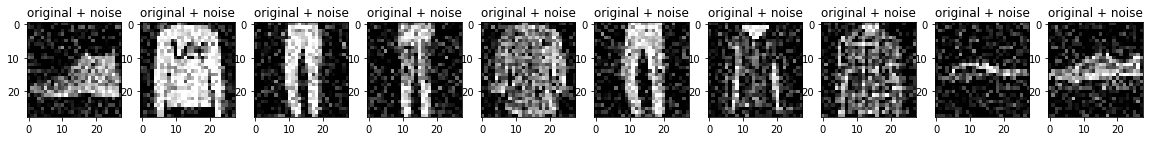

In [25]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [39]:
latent_dim = 64

class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.C1 = tf.keras.layers.Conv2D(8, kernel_size = 3, strides = (1,1), padding = 'same', activation = 'relu')
    self.C2 = tf.keras.layers.Conv2D(1, kernel_size = 5, strides = (1,1), padding = 'valid', activation = 'relu')
    self.C3 = tf.keras.layers.Conv2D(8, kernel_size = 3, strides = (1,1), padding = 'same', activation = 'relu')
    self.flatten  = tf.keras.layers.Flatten()
    self.fc = tf.keras.layers.Dense(784)
    self.reshapes = tf.keras.layers.Reshape((28,28))

  def call(self, x):
    x = self.C1(x)
    x = self.C2(x)
    x = self.C3(x)
    x = self.flatten(x)
    x = self.fc(x)
    x = self.reshapes(x)
    return x

autoencoder = Denoise()

In [40]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [42]:
# Train 
autoencoder.fit(x_train_noisy, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss:

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

The decoder upsamples the images back from 7x7 to 28x28.

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [43]:
# Reconstruct test images 
################ Implementation ################
x = autoencoder.C1(x_test_noisy)
x = autoencoder.C2(x)
x = autoencoder.C3(x)
x = autoencoder.flatten(x)
x = autoencoder.fc(x)
x = autoencoder.reshapes(x)
decoded_imgs = x
################ Implementation ################

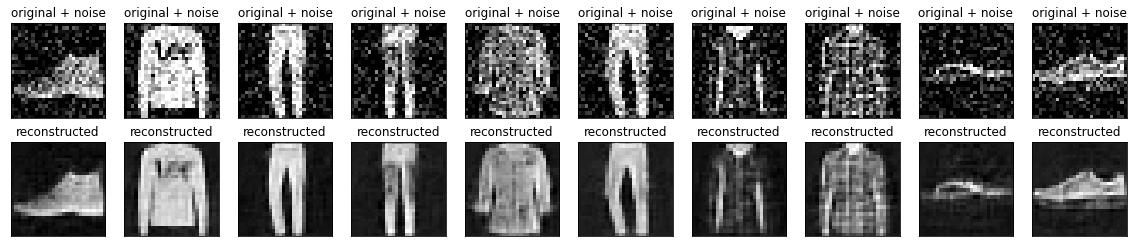

In [44]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# T-SNE 

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

def plot_tsne(inputs, labels):
  n_samples = len(labels)
  tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
  tsne_features = tsne.fit_transform(inputs[:n_samples].reshape(n_samples, -1))
  df = pd.DataFrame({
      'x': tsne_features[:,0],
      'y': tsne_features[:,1],
      'label': labels[:n_samples]
  })

  sns.scatterplot(data=df, x='x', y='y', hue='label', palette="deep")

In [ ]:
n_samples = 1000
plot_tsne(x_train_noisy[:n_samples].numpy(), y_train[:n_samples])

In [ ]:
z_train = autoencoder.encoder(x_train_noisy[:n_samples]).numpy()
plot_tsne(z_train, y_train[:n_samples])